# Table of Contents:

* **1. Project Question & Attributes:**
  * 1.1 Project Question.<br>
  * 1.2 Attributes.<br>
* **2. Features Exploration & Engineering:**
  * 2.1 Features Exploration.<br>
  * 2.2 Features Engineering.<br>
* **3. Analysis of Features Over Time:**
  * 3.1 Features Changes over Time.<br>
  * 3.2 Features Correlation with Time (year).<br>
  * 3.3 Analysis Conclusion.<br>
* **4. Observations Clustering:**
  * 4.1 Define a Clustering Function.<br>
  * 4.2 Test the Function.<br>

## Importing Libraries:

In [1100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import LabelEncoder
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

---

# 1. Features Question & Attributes

## 1.1 Project Question:

#### Is the movie industry dying? How can we categorize movies according to different features?

---

## 1.2 Attributes:

#### There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

* budget: the budget of a movie. Some movies don't have this, so it appears as 0<br>
* company: the production company<br>
* country: country of origin<br>
* director: the director<br>
* genre: main genre of the movie<br>
* gross: revenue of the movie<br>
* name: name of the movie<br>
* rating: rating of the movie (R, PG, etc.)<br>
* released: release date (YYYY-MM-DD)<br>
* runtime: duration of the movie<br>
* score: IMDb user rating<br>
* votes: number of user votes<br>
* star: main actor/actress<br>
* writer: writer of the movie<br>
* year: year of release<br>

---

# 2. Features Exploration & Engineering

## 2.1 Features Exploration:

#### Let's start off the journey of finding the answers by uploading the data and have a look over the different features:

In [1101]:
# Upload data
movies = pd.read_csv('movies.csv', encoding = "ISO-8859-1")

# Have a look on the data structure and types
movies.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [1102]:
# Check if there are missing observations
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
budget      6820 non-null float64
company     6820 non-null object
country     6820 non-null object
director    6820 non-null object
genre       6820 non-null object
gross       6820 non-null float64
name        6820 non-null object
rating      6820 non-null object
released    6820 non-null object
runtime     6820 non-null int64
score       6820 non-null float64
star        6820 non-null object
votes       6820 non-null int64
writer      6820 non-null object
year        6820 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


In [1103]:
for index in ['budget', 'gross', 'runtime', 'score', 'votes', 'year']:
    print(index, 'min =', movies[index].min(), '&', index, 'max =', movies[index].max())

budget min = 0.0 & budget max = 300000000.0
gross min = 70.0 & gross max = 936662225.0
runtime min = 50 & runtime max = 366
score min = 1.5 & score max = 9.3
votes min = 27 & votes max = 1861666
year min = 1986 & year max = 2016


In [1104]:
len(movies[movies['budget'] == 0])

2182

#### According to the above counting, there are no missing observation within our movie dataset. Only "budget" observations with zero value needs to be updated.

## 2.2 Features Engineering:

#### Now, let's encode our categorical data to be able to use it in the upcoming analysis:

In [1105]:
labelencoder_X = LabelEncoder()
movies.loc[:, 'company'] = labelencoder_X.fit_transform(movies.loc[:, 'company'])
movies.loc[:, 'country'] = labelencoder_X.fit_transform(movies.loc[:, 'country'])
movies.loc[:, 'director'] = labelencoder_X.fit_transform(movies.loc[:, 'director'])
movies.loc[:, 'genre'] = labelencoder_X.fit_transform(movies.loc[:, 'genre'])
movies.loc[:, 'name'] = labelencoder_X.fit_transform(movies.loc[:, 'name'])
movies.loc[:, 'rating'] = labelencoder_X.fit_transform(movies.loc[:, 'rating'])
movies.loc[:, 'star'] = labelencoder_X.fit_transform(movies.loc[:, 'star'])
movies.loc[:, 'writer'] = labelencoder_X.fit_transform(movies.loc[:, 'writer'])

#### By having a look over the data, we can conclude that some amendments can further smooth the analysis, like breaking down released date (which might be used in the last step "clustering"), replace zero budgets with median, and create a new copied dataset that will have a grouped 'year' feature as a 4 years intervals which will be used shortly in the analysis

In [1106]:
# Break down (released date) into (year, month & day)
movies['rel_year'] = movies['released'].apply(lambda x: x[:4]).astype(int)
movies['rel_month'] = 0
movies['rel_day'] = 0

# Update 'rel_month' and 'rel_day' columns with the corresponding values from 'released' feature
for index in range(0, len(movies)):
    if len(movies.released[index]) == 10:
        movies.loc[index, 'rel_month'] = movies.loc[index, 'released'][5:7]
        movies.loc[index, 'rel_day'] = movies.loc[index, 'released'][8:10]
        
# For 'released' observations with length less than 10, we can update their corresponding 'rel_month' & 'rel_day' with median
month_avg = movies[movies['rel_month'] != 0]['rel_month'].median()
day_avg = movies[movies['rel_day'] != 0]['rel_day'].median()

# Update observations with length less than 10 with the average of each feature
for index in range(0, len(movies)):
    if len(movies.released[index]) != 10:
        movies.loc[index, 'rel_month'] = month_avg
        movies.loc[index, 'rel_day'] = day_avg

# Convert 'rel_month' & 'rel_day' types to (int)
movies['rel_month'] = movies['rel_month'].astype(int)
movies['rel_day'] = movies['rel_day'].astype(int)

# Delete 'released' feature since it has no importance now
del(movies['released'])

# Replace zero 'budget' observations with 'budget' median
budget_avg = movies['budget'].median()

for index in range(0, len(movies)):
    if movies.budget[index] == 0:
        movies.loc[index, 'budget'] = budget_avg

# Create a copied dataset to to group some of its features' values for a better visualization through different cross tables
data = movies.copy()

# Group the values of year feature
for number in range(1980, 2020, 4):
    data.loc[(data['year'] > number) & (data['year'] <= (number + 4)), 'year'] = number + 4

---

# 3. Analysis of Features Over Time

## 3.1 Features Changes over Time:

#### Having a look on the progress of different features over time might seem a good idea

In [1107]:
# Create lists that hold features according to each needed computation (total, sum or average)
total = ['company', 'country', 'director', 'genre', 'name', 'star', 'writer', 'rating']
summing = ['budget', 'gross', 'votes']
aver = ['runtime', 'score']

# Display each feature's progress over consecutive time intervals (4 years) using the relevant computation
for index in range(0, len(total)):
    print("Progress of '%s' over time:\n" % total[index])
    for year in data.year.unique():
        print('Total unique %s in the interval ending in %i is: %i' % (total[index], year, data[data['year'] == year][total[index]].nunique()))
    print('\n')

print('----------------------------------------------------------------------------\n')

for index in range(0, len(summing)):
    print("Progress of '%s' over time:\n" % summing[index])
    for year in data.year.unique():
        print('The sum of %s in the interval ending in %i is: %i million' % (summing[index], year, data[data['year'] == year][summing[index]].sum() / 1000000))
    print('\n')

print('----------------------------------------------------------------------------\n')

for index in range(0, len(aver)):
    print("Progress of '%s' over time:\n" % aver[index])
    for year in data.year.unique():
        print('%s median in the interval ending in %i is: %i' % (aver[index], year, data[data['year'] == year][aver[index]].median()))
    print('\n')

Progress of 'company' over time:

Total unique company in the interval ending in 1988 is: 305
Total unique company in the interval ending in 1992 is: 407
Total unique company in the interval ending in 1996 is: 349
Total unique company in the interval ending in 2000 is: 405
Total unique company in the interval ending in 2004 is: 357
Total unique company in the interval ending in 2008 is: 344
Total unique company in the interval ending in 2012 is: 384
Total unique company in the interval ending in 2016 is: 469


Progress of 'country' over time:

Total unique country in the interval ending in 1988 is: 19
Total unique country in the interval ending in 1992 is: 29
Total unique country in the interval ending in 1996 is: 29
Total unique country in the interval ending in 2000 is: 32
Total unique country in the interval ending in 2004 is: 31
Total unique country in the interval ending in 2008 is: 30
Total unique country in the interval ending in 2012 is: 32
Total unique country in the interval 

#### From the above simple analysis, we can conclude the following:<br>

1- Number of movies' making companies is increasing over time.<br>
2- Number of movies' countries of origin is increasing over time.<br>
3- Directors are increasing slowly each new interval.<br>
4- The progress of movies genre was slightly decreased but started to slightly increase again as of 2008.<br>
5- According to the provided data, number of movies released in each interval has been almost the same since 1992.<br>
6- Number of main actor/actress (stars) for each interval hasn't been dramatically changing over different intervals.<br>
7- The percentage of writers writing each interval's movies has been decreasing with a very low rate since 2000.<br>
8- Number of ratings in each interval has been almost consistent.<br>
9- Total budget and gross (as well as profit) were increasing with a few billions of dollars over time.<br>
10- Number of users' votes was dramatically increasing up till the last interval (2012-2016) in which it started to decrease.<br>
11- The average duration of movies (runtime) were slightly increasing.<br>
12- Average scores on IMDb given by users for each interval's movies was almost steady.<br>

## 3.2 Features Correlation with Time (year):

#### Another side to look at the progress could be through checking the correlation between year and different original quantitative features (features that havn't been converted "encoded" from categorical to quantitative) as displayed below (they all have a positive correlation).

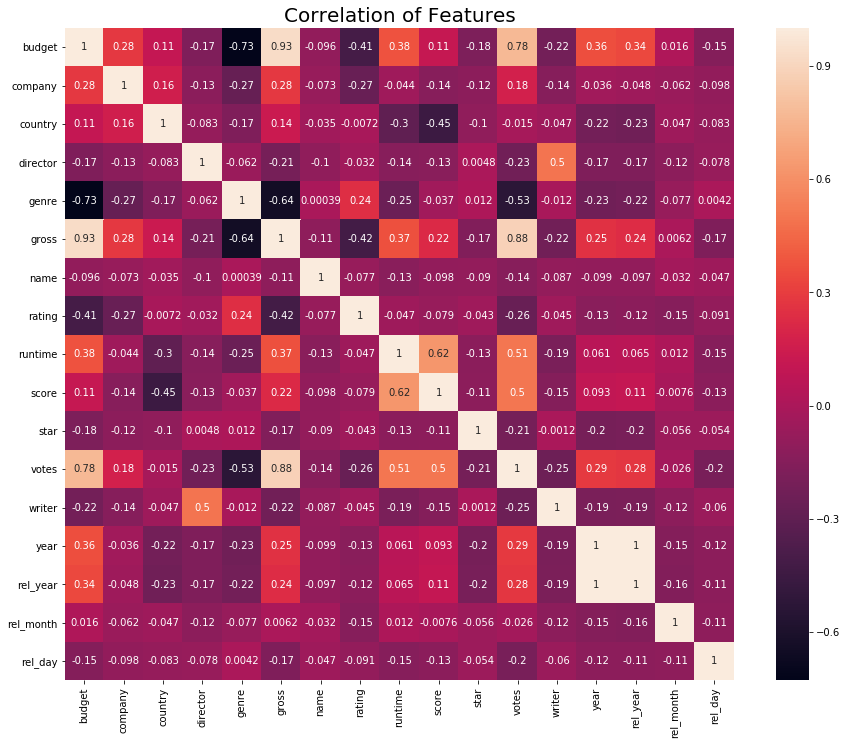

In [1108]:
# Set the dimensions of the headmap
plt.figure(figsize=(15,12))

# Set a title and plot the heatmap
plt.title('Correlation of Features', fontsize=20)
sns.heatmap(data.corr().astype(float).corr(),vmax=1.0, annot=True)
plt.show()

## 3.3 Analysis Conclusion:

#### As a conclusion, to answer a question like whether movie industry is dying or not, if we decide to measure the progress of the industry according to the changes of any of the available features over time, we will find that almost all features are booming with different rates over time. This can be conceived as a flourishing sign for the movie industry. 

---

# 4. Observations Clustering

## 4.1 Define a Clustering Function:

#### Let's now define a function that can help in clustering the observations according to any features we decide:

In [1114]:
# Define the function with it's parameters (below is the description of each parameter):

# data: The data that will be used to train the model in order to form the clusters
# features: Which features from the dataset will be considered in the clustering
# display_clusters: Specify two features to check how clustering between them looks like
# clusters: If 0, the model will calculate the best number of clusters to be used. If a value has been set manually, the user can decide the number of clusters s/he wants to cluster upon
# predict: If (True), the model will check which cluster each observation in the sample dataset (new_data) belongs to
# display_methods: If (True), the elbow and dendrogram graphs 
# centroids: Display the centroid of each cluster

def clusters (data = pd.DataFrame(), features = [], display_clusters = [], clusters = 0, predict = False, display_methods = False, centroids = False):
    
    # Create a list of features from the provided data's columns' in case the features are not provided as argument
    if (len(features) == 0):
        features = []
        for index in range(0, len(data.columns)):
                features.append(data.columns[index])

    # Consider only the specified features if the user placed a value for it while calling the function 
    else:
        data = data.loc[:, features]
    
    # Create 'X' object
    X = data.values
    
    # List to store the within clusters sum of squares (wcss) for each number of clusters to check at which number of clusers the value of wcss will not be decreased significantly anymore
    wcss = []
    
    # Set the range that will be used in several steps below in case of manually defining number of clusters 
    if clusters != 0:
        clust_range = range(1, clusters + 1)
    
    # Set the range that will be used in several steps below in case the model will detect the best number of clusters
    else:
        clust_range = range(1, 11)

    # Detect the value of wcss corresponding to each number of clusters within the specified range above 
    for i in clust_range:
        kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300, n_init = 10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # List that will store the differences in wcss percentages' changes in order to determine the best number of clusters in which any number of clusters after it won't drop the wcss value significantly
    difference = []
    
    # determine the best number of clusters (in case it's not set manually)
    if (clusters == 0): 
        for i in range(0, 8):
            difference.append((1 - (wcss[i + 1] / wcss[i])) - (1 - (wcss[i + 2] / wcss[i + 1])))
        clusters = difference.index(max(difference)) + 2
    
    # Create an object with the corresponding cluster for each observation
    kmeans = KMeans(n_clusters = clusters, init = 'random', max_iter = 300, n_init = 10, random_state = 0)
    y_kmeans = kmeans.fit_predict(X)
    
    # List of colors that will differentiate each cluster
    color = ['red', 'blue', 'green', 'brown', 'blueviolet', 'black', 'lightgrey', 'olive', 'peru', 'yellow']
    
    # Display a graph that will show the clusters associated with the observations of any specified two features    
    if (len(display_clusters) == 2):
        for feature in features:
            if display_clusters[0] == feature:
                for feature in features:
                    if display_clusters[1] == feature:
                        for cluster in range(0, clusters):
                            plt.scatter(X[y_kmeans == cluster, features.index(display_clusters[0])], X[y_kmeans == cluster, features.index(display_clusters[1])], s = 50, c= color[cluster], label = str(cluster))
                        if (centroids):
                            plt.scatter(kmeans.cluster_centers_[:, features.index(display_clusters[0])], kmeans.cluster_centers_[:, features.index(display_clusters[1])], s = 100, c= 'orange', label = 'Centroids')
                        plt.title('Clustering %s & %s' % (display_clusters[0], display_clusters[1]))
                        plt.xlabel(display_clusters[0])
                        plt.ylabel(display_clusters[1])
                        plt.legend()
                        plt.show()
    
    # Display the elbow method and dendrogram graphically (if display_methods = True)
    if (display_methods):
        
        plt.plot(clust_range, wcss)
        plt.title('The Elbow Method')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS')
        plt.show()

        dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
        plt.title('Dendrogram')
        plt.ylabel('Euclidean distances')
        plt.show()

    # Predict the cluster of each observation in the sample dataset 'new_data' (if predict = True)
    if (predict):
        global new_data
        new_data = data.copy()
        new_data['cluster'] = kmeans.predict(new_data.values)
        display(new_data)
        print('\nThe above dataset is stored under the name of "new_data"')
    

---

## 4.2 Test the Function:

#### It's time to test the function with different scenarios:

#### Here, we specified the dataset and features that will be involved in the clustering process, features that we want to visually check their corresponding clusters, as well as visualizing the graphs for elbow method and dendrogram used to determine the best number of clusters:

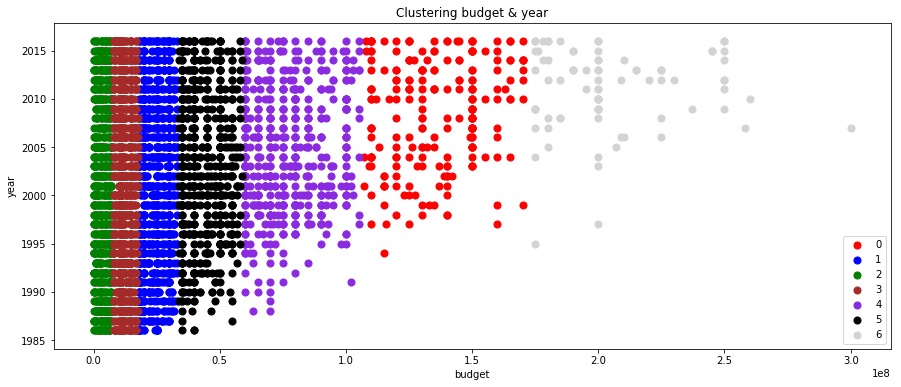

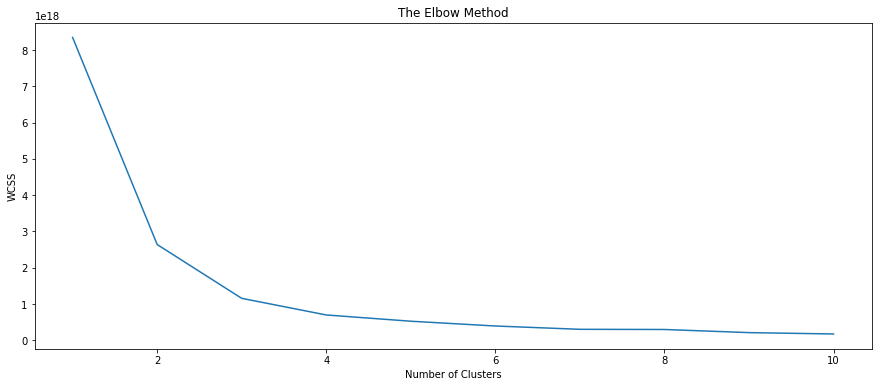

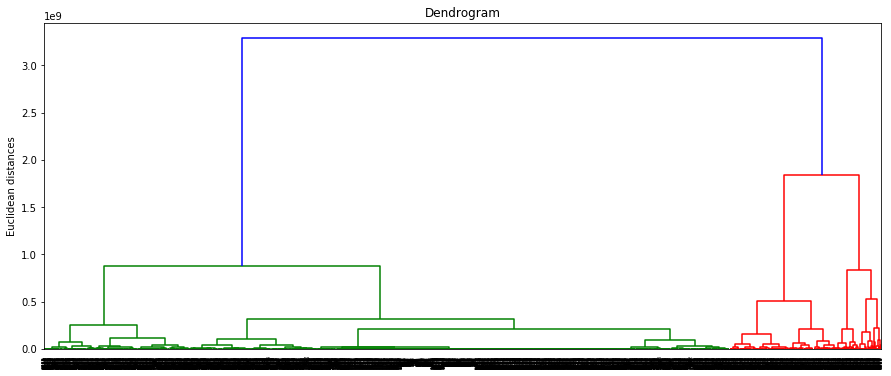

In [1110]:
clusters(data = movies, features = ['budget', 'year'], display_clusters = ['budget', 'year'], display_methods = True)


#### In the below scenario, there was a manual specification to the number of clusters we wanted to fit our observations to and displayed the centroid of each cluster:

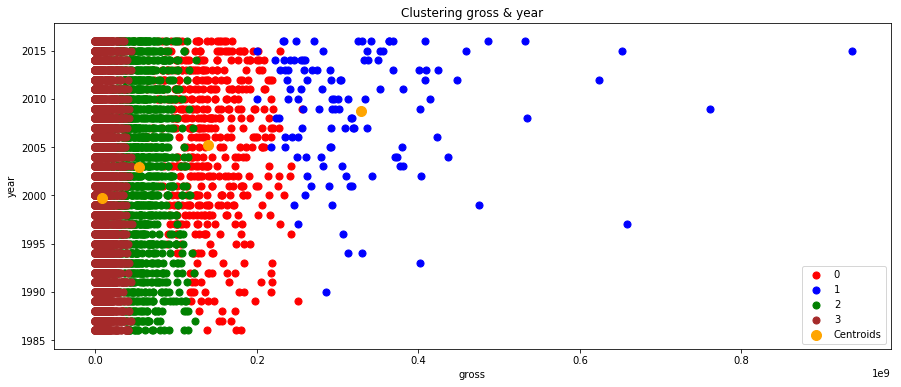

In [1118]:
clusters(data = movies, display_clusters = ['gross', 'year'], clusters = 4, centroids = True)

#### Lastly, create a dataset with the corresponding cluster for each observation according to the specified features:

In [1112]:
clusters(data = movies, features = ['gross', 'votes', 'writer'], clusters = 5, predict = True)

,gross,votes,writer,cluster
0,52287414.0,299174,3716,3
1,70136369.0,264740,1970,3
2,179800601.0,236909,1852,2
3,85160248.0,540152,1629,4
4,18564613.0,36636,2549,1
5,138530565.0,317585,2988,4
6,12729917.0,102879,977,1
7,8551228.0,146768,897,1
8,40471663.0,60565,1970,3
9,40456565.0,129698,1333,3



The above dataset is stored under the name of "new_data"


#### As seen above, we can use the function to display the needed visualization or predict the clusters according to our needs.